In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
import sparsetools as sp
from matplotlib.colors import LogNorm
import os

In [2]:
#mod_tau = sp.model('test_col200_mod_ltau_noalma_2.nc')
mod_tau = sp.model('../band3/alma/alma_mod_2_ltau.nc')
#mod_xi = sp.model('test_col200_mod_noalma_2.nc')
mod_xi = sp.model('../band3/alma/alma_mod_2_redux.nc').extract(x1=320,y1=320)

model::read: atmos type -> depth-stratified
model::read: nx=320, ny=320, ndep=61, nt=1
model::setSize: nx = 320, ny = 320, ndep = 61, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=334, ny=334, ndep=61, nt=1
model::setSize: nx = 334, ny = 334, ndep = 61, nt = 1
model::extract: x=(0,320), y=(0,320), z=(0,61), t=(0,1)
model::setSize: nx = 320, ny = 320, ndep = 61, nt = 1


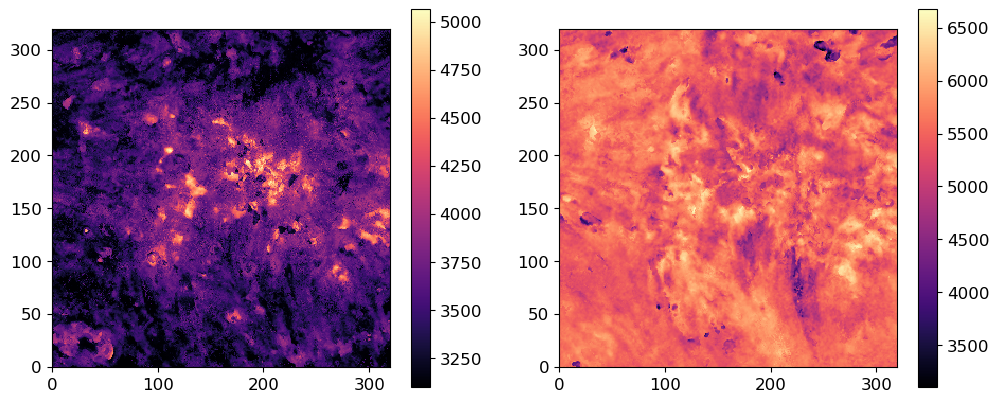

In [3]:
#plt.figure(figsize=(10,4))
#plt.subplot(121)
#plt.imshow(mod_tau.temp[0,:,0].T,cmap='magma',aspect='auto',vmin=3000,vmax=13000,norm=LogNorm())
#plt.subplot(122)
#plt.imshow(mod_xi.temp[0,:,0].T,cmap='magma',aspect='auto',vmin=3000,vmax=13000,norm=LogNorm())
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(mod_tau.temp[0,:,:,20],cmap='magma',origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(mod_xi.temp[0,:,:,20],cmap='magma',origin='lower')
plt.colorbar()

In [4]:
from scipy.interpolate import interp1d
xi_to_tau = np.zeros((320,320,61))
tau_to_xi = np.zeros((320,320,61))
for i in range(320):
    for j in range(320):
        xi_to_tau[i,j] = interp1d(mod_xi.ltau[0,i,j],mod_xi.temp[0,i,j],\
                                  fill_value='extrapolate')(mod_tau.ltau[0,i,j])
        tau_to_xi[i,j] = interp1d(mod_tau.cmass[0,i,j],mod_tau.temp[0,i,j],\
                                  fill_value='extrapolate')(mod_xi.cmass[0,i,j])

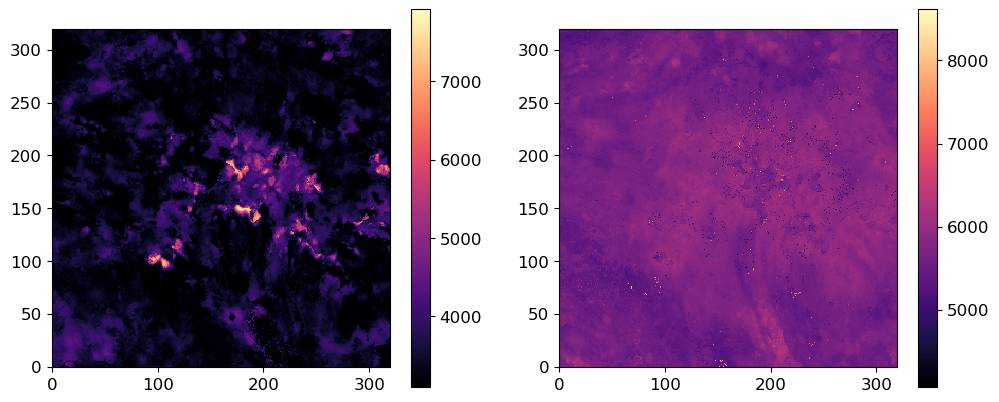

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(xi_to_tau[:,:,20],cmap='magma',origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(tau_to_xi[:,:,20],cmap='magma',origin='lower')
plt.colorbar()

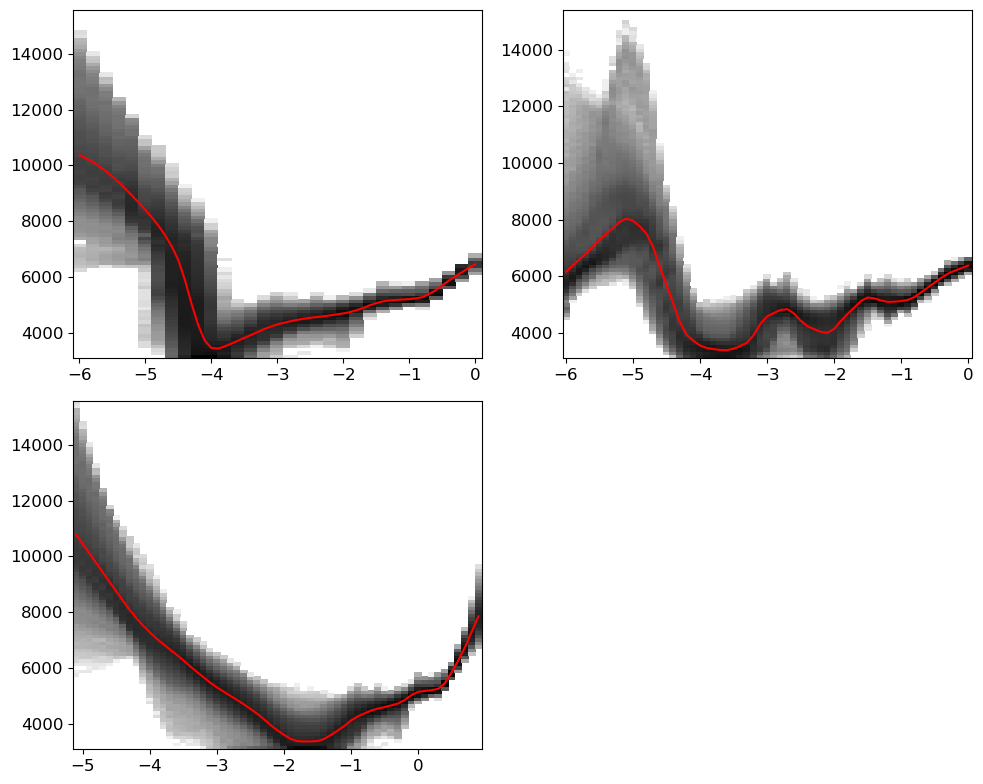

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist2d(mod_xi.ltau.ravel(),mod_xi.temp.ravel(),bins=[np.arange(32)*0.2-6.1,100],cmap='gist_yarg',norm=LogNorm())
plt.plot(np.arange(61)*0.1-6,np.mean(xi_to_tau,(0,1)),'-r')
plt.subplot(222)
plt.hist2d(mod_tau.ltau.ravel(),mod_tau.temp.ravel(),bins=[np.arange(62)*0.1-6.05,100],cmap='gist_yarg',norm=LogNorm())
plt.plot(np.arange(61)*0.1-6,np.mean(mod_tau.temp[0],(0,1)),'-r')
plt.subplot(223)
plt.hist2d(mod_xi.cmass.ravel(),mod_xi.temp.ravel(),bins=[np.arange(62)*0.1-5.15,100],cmap='gist_yarg',norm=LogNorm())
plt.plot(np.arange(61)*0.1-5.1,np.mean(mod_xi.temp[0],(0,1)),'-r')
plt.tight_layout()

In [12]:
x = np.arange(61)*0.1-6
deg = 3
xi_fit = np.zeros((320,320,deg+1))
xi_res = np.zeros((320,320,61))
xi_rms = np.zeros((320,320))
tau_fit = np.zeros((320,320,deg+1))
tau_res = np.zeros((320,320,61))
tau_rms = np.zeros((320,320))
for i in range(320):
    for j in range(320):
        x_min = 61 - np.argmin(xi_to_tau[i,j,::-1])
        xi_fit[i,j] = np.polynomial.polynomial.polyfit(x[x_min:],xi_to_tau[i,j,x_min:],deg)
        for k in range(deg+1):
            xi_res[i,j,x_min:] -= xi_fit[i,j,k]*x[x_min:]**k
        xi_res[i,j,x_min:] += xi_to_tau[i,j,x_min:]
        xi_rms[i,j] = np.std(xi_res[i,j,x_min:])
        x_min = 61 - np.argmin(mod_tau.temp[0,i,j,::-1])
        tau_fit[i,j] = np.polynomial.polynomial.polyfit(x[x_min:],mod_tau.temp[0,i,j,x_min:],deg)
        for k in range(deg+1):
            tau_res[i,j,x_min:] -= tau_fit[i,j,k]*x[x_min:]**k
        tau_res[i,j,x_min:] += mod_tau.temp[0,i,j,x_min:]
        tau_rms[i,j] = np.std(tau_res[i,j,x_min:])

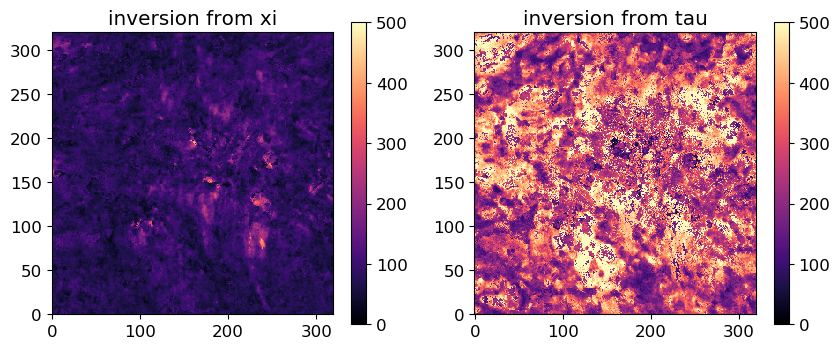

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(xi_rms,origin='lower',cmap='magma',vmin=0,vmax=500)
plt.title('inversion from xi')
plt.colorbar()
plt.subplot(122)
plt.imshow(tau_rms,origin='lower',cmap='magma',vmin=0,vmax=500)
plt.title('inversion from tau')
plt.colorbar()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-6.05, -5.95, -5.85, -5.75, -5.65, -5.55, -5.45, -5.35, -5.25,
        -5.15, -5.05, -4.95, -4.85, -4.75, -4.65, -4.55, -4.45, -4.35,
        -4.25, -4.15, -4.05, -3.95, -3.85, -3.75, -3.65, -3.55, -3.45,
        -3.35, -3.25, -3.15, -3.05, -2.95, -2.85, -2.75, -2.65, -2.55,
        -2.45, -2.35, -2.25, -2.15, -2.05, -1.95, -1.85, -1.75, -1.65,
        -1.55, -1.45, -1.35, -1.25, -1.15, -1.05, -0.95, -0.85, -0.75,
        -0.65, -0.55, -0.45, -0.35, -0.25, -0.15, -0.05,  0.05]),
 array([-1000.,  -980.,  -960.,  -940.,  -920.,  -900.,  -880.,  -860.,
         -840.,  -820.,  -800.,  -780.,  -760.,  -740.,  -720.,  -700.,
         -680.,  -660.,  -640.,  -620.,  -600.,  -580.,  -560.,  -540.,
         -520.,  -500.,  -480.,  -460.,  -4

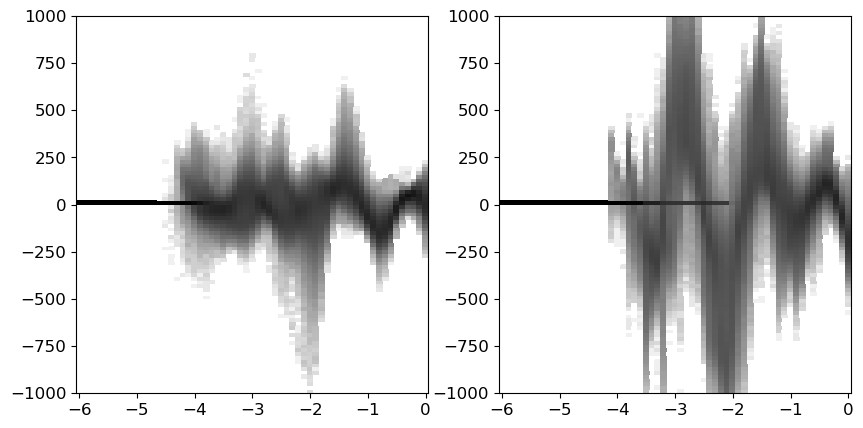

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist2d(mod_tau.ltau.ravel(),xi_res.ravel(),\
           bins=[np.arange(62)*0.1-6.05,np.linspace(-1000,1000,101)],cmap='gist_yarg',norm=LogNorm())
plt.subplot(122)
plt.hist2d(mod_tau.ltau.ravel(),tau_res.ravel(),\
           bins=[np.arange(62)*0.1-6.05,np.linspace(-1000,1000,101)],cmap='gist_yarg',norm=LogNorm())

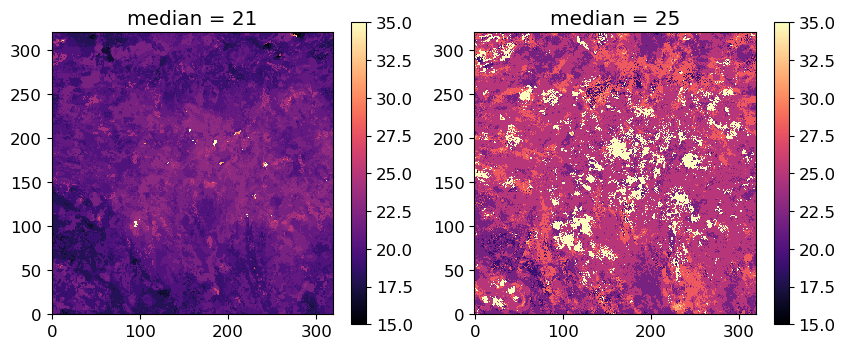

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(61-np.argmin(xi_to_tau[:,:,::-1],2),cmap='magma',origin='lower',vmin=15,vmax=35)
plt.title('median = {:.0f}'.format(np.median(61-np.argmin(xi_to_tau[:,:,::-1],2))))
plt.colorbar()
plt.subplot(122)
plt.imshow(61-np.argmin(mod_tau.temp[0,:,:,::-1],2),cmap='magma',origin='lower',vmin=15,vmax=35)
plt.title('median = {:.0f}'.format(np.median(61-np.argmin(mod_tau.temp[0,:,:,::-1],2))))
plt.colorbar()

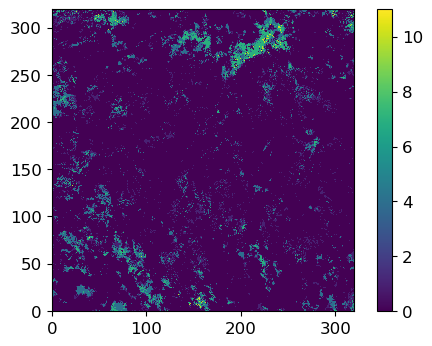

In [17]:
a = xi_to_tau
b = mod_tau.temp[0]
plt.imshow(np.sum(np.where(b == 3100,1,0),2),origin='lower')
plt.colorbar()